### Importing Libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (8, 5)

### Loading and preparing data:

In [17]:
df_preprocessed = pd.read_csv('../data/processed_heart_disease.csv')

X = pd.read_csv("../data/X_selected_features.csv")
y = df_preprocessed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing set size: X_test: {X_test.shape}, y_test: {y_test.shape}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

print("Features are ready for modeling.")

Training set size: X_train: (736, 10), y_train: (736,)
Testing set size: X_test: (184, 10), y_test: (184,)
Features are ready for modeling.


### Defining Models and Parameter Grids:

In [18]:
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1,2]
}


svm_model = SVC(random_state=42, probability=True)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}


lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

dt_model = DecisionTreeClassifier(random_state=42)
dt_param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

models_to_tune = {
    'Random Forest': (rf_model, rf_param_grid),
    'SVM': (svm_model, svm_param_grid)
    # 'Logisitc Regression': (lr_model, lr_param_grid),
    # 'Decision Tree': (dt_model, dt_param_grid)
}

tuning_results = {}

### Hyper Parameter Tuning:

In [19]:
print("--- Starting Hyperparameter Tuning ---")

for model_name, (model, param_grid) in models_to_tune.items():
    print(f"\nTuning {model_name}")
    
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    
    grid_search.fit(X_train_scaled, y_train)
   
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    tuning_results[model_name] = {
        'best_model': best_model,
        'best_params': best_params,
        'best_cv_score': best_score,
        'grid_search_object': grid_search
    }
    
    print(f"Best parameters for {model_name}: {best_params}")
    print(f"Best cross-validation score for {model_name}: {best_score:.4f}")
    
print("\n--- Hyperparameter Tuning Completed ---")

--- Starting Hyperparameter Tuning ---

Tuning Random Forest
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.8139

Tuning SVM
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for SVM: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation score for SVM: 0.8207

--- Hyperparameter Tuning Completed ---


### Evaluating Tuned Models:


--- Evaluating Tuned Models on Test Set ---

--- Evaluating Best Random Forest ---
Test Accuracy: 0.8261
Test Precision: 0.8738
Test Recall: 0.8257
Test F1-Score: 0.8491
Test ROC AUC: 0.9024
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.79        75
           1       0.87      0.83      0.85       109

    accuracy                           0.83       184
   macro avg       0.82      0.83      0.82       184
weighted avg       0.83      0.83      0.83       184



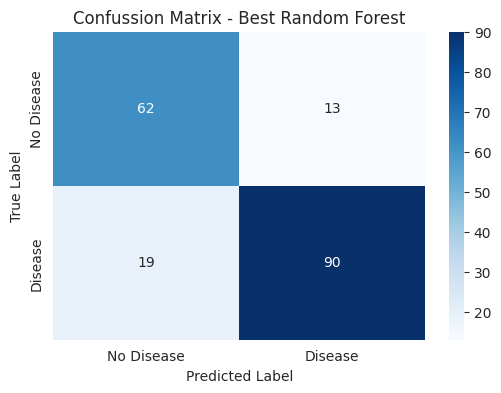


--- Final Evaluation Summary (Test Set) ---
               Accuracy Precision    Recall  F1-Score   ROC AUC Best_CV_Score
Random Forest  0.826087  0.873786  0.825688  0.849057  0.902385      0.813927

--- Evaluating Best SVM ---
Test Accuracy: 0.7989
Test Precision: 0.8396
Test Recall: 0.8165
Test F1-Score: 0.8279
Test ROC AUC: 0.8774
Best Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.76        75
           1       0.84      0.82      0.83       109

    accuracy                           0.80       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.80      0.80      0.80       184



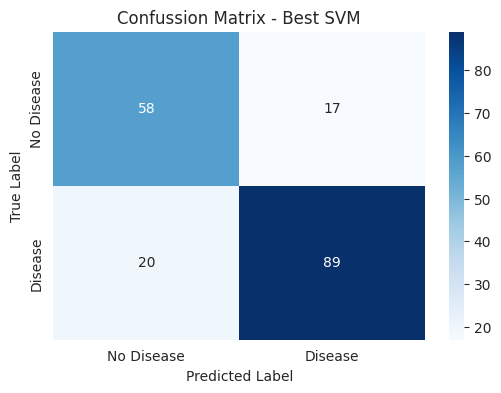


--- Final Evaluation Summary (Test Set) ---
               Accuracy Precision    Recall  F1-Score   ROC AUC Best_CV_Score
Random Forest  0.826087  0.873786  0.825688  0.849057  0.902385      0.813927
SVM            0.798913  0.839623  0.816514  0.827907  0.877431      0.820684


In [20]:
print('\n--- Evaluating Tuned Models on Test Set ---')

final_evaluation_results = {}

for model_name, results in tuning_results.items():
    best_model = results['best_model']
    print(f"\n--- Evaluating Best {model_name} ---")
    
    
    y_pred = best_model.predict(X_test_scaled)
    y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    final_evaluation_results[model_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc,
        'Best_Params': results['best_params'],
        'Best_CV_Score': results['best_cv_score']
    }
    
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1-Score: {f1:.4f}")
    print(f"Test ROC AUC: {roc_auc:.4f}")
    print(f"Best Parameters: {results['best_params']}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Disease', 'Disease'], 
                yticklabels=['No Disease', 'Disease'])
    plt.title(f"Confussion Matrix - Best {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel('True Label')
    plt.show()
    
    print("\n--- Final Evaluation Summary (Test Set) ---")
    results_df = pd.DataFrame(final_evaluation_results).T
    print(results_df[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC', 'Best_CV_Score']])
    

### Comparing with BaseLine models 

In [21]:
baseline_results = {
    'Random Forest (Baseline)': {'Accuracy': 0.82, 'F1-Score': 0.84, 'ROC AUC': 0.9},
    'SVM (Baseline)': {'Accuracy': 0.75, 'F1-Score': 0.78, 'ROC AUC': 0.77}
}

comparison_df = pd.DataFrame({
    'Tuned': results_df['F1-Score'],
    'Baseline': [baseline_results.get(name, {}).get('F1-Score', np.nan) for name in results_df.index]
})

print("\n--- Comparison: Tuned vs Baseline (F1-Score) ---")
print(comparison_df)


--- Comparison: Tuned vs Baseline (F1-Score) ---
                  Tuned  Baseline
Random Forest  0.849057       NaN
SVM            0.827907       NaN


### Selecting and Saving the Best Overall Model:

In [22]:
best_overall_model_name = results_df['F1-Score'].idxmax()
best_overall_model = tuning_results[best_overall_model_name]['best_model']
best_overall_score = results_df.loc[best_overall_model_name, 'F1-Score']

print(f"\n--- Best Overall Model (based on F1-Score) ---")
print(f"Model: {best_overall_model_name}")
print(f"F1-Score on Test Set: {best_overall_score:.4f}")
print(f"Parameters: {tuning_results[best_overall_model_name]['best_params']}")


import joblib
model_save_path = '../models/final_model.pkl'
joblib.dump(best_overall_model, model_save_path)
print(f"\nBest model saved to: {model_save_path}")

results_save_path = '../results/hyperparameter_tuning_resutls.csv'
results_df.to_csv(results_save_path)
print(f"Tuning results saved to: {results_save_path}")


--- Best Overall Model (based on F1-Score) ---
Model: Random Forest
F1-Score on Test Set: 0.8491
Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}

Best model saved to: ../models/final_model.pkl
Tuning results saved to: ../results/hyperparameter_tuning_resutls.csv
